In [1]:
import os
import glob
import gzip
import numpy as np
import pandas as pd
import pickle
from rdkit import Chem
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable

import math, random, sys
from optparse import OptionParser
from collections import deque

from icml18_jtnn.jtnn import *
import rdkit
import csv


In [2]:
os.listdir()

Out[2]: ['conf', 'logs', 'derby.log', 'ganglia', 'eventlogs']

In [3]:
datasets = ["Homopiperazines","Piperazines","Piperidines","Sulphamides"]
names = ["JAK1 EC50 nM 1027","JAK2 EC50 nM 1024","JAK3 EC50 nM 1026"]
names = names + ['TYK2 EC50 nM 1025']
files = ["/dbfs/FileStore/tables/Homopiperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperidines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Sulphamides_cleaned_Feb_2019.sdf",
        ]
PARENT_DIR = '/dbfs/FileStore/tables'
PICKLES_DIR = '/dbfs/FileStore/pickles'
MODEL_DIR = os.path.join(PICKLES_DIR, "jtvae_model")
MOSES_DIR = '/dbfs/FileStore/moses'


In [4]:
#full_descriptors = pickle.load(open('/'.join([PICKLES_DIR,'20190317-full_descriptors.p']),'rb'))
full_internal = pickle.load(open('/'.join([PICKLES_DIR,'20190317-full_internal.p']),'rb')).dropna(subset=names)
print(full_internal.shape)

(1825, 25)

In [5]:
from molvs import Standardizer
s = Standardizer()
full_internal['Isomeric_canon'] = [Chem.MolToSmiles(s.standardize(Chem.MolFromSmiles(smi)), canonical = True) for smi in full_internal['Canonical Smiles']]

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(full_internal.filter(['Isomeric_canon']), full_internal.filter(names), test_size=0.2, random_state=7)

full_internal.filter(['Isomeric_canon']).to_csv(os.path.join(PARENT_DIR,'full_smiles.txt'), header=None,index=False)
X_train.filter(['Isomeric_canon']).to_csv(os.path.join(PARENT_DIR,'X_train_smiles.txt'), header=None,index=False)
X_test.filter(['Isomeric_canon']).to_csv(os.path.join(PARENT_DIR,'X_test_smiles.txt'), header=None,index=False)
for name in names:
  full_internal.filter([name]).to_csv(os.path.join(PARENT_DIR,name+'-full.txt'), header=None,index=False)
  y_train.filter([name]).to_csv(os.path.join(PARENT_DIR,name+'-y_train.txt'), header=None,index=False)
  y_test.filter([name]).to_csv(os.path.join(PARENT_DIR,name+'-y_test.txt'), header=None,index=False)

In [7]:
X_train = pd.read_csv(os.path.join(PARENT_DIR,'X_train_smiles.txt'), header=None, squeeze=True).astype(str).tolist()
X_test = pd.read_csv(os.path.join(PARENT_DIR,'X_test_smiles.txt'), header=None, squeeze=True).astype(str).tolist()

In [8]:
zinc_13t09 = pd.read_csv('/dbfs/FileStore/ZINC/13_t90.smi',sep='\t', header=None)
zinc_13t09 = zinc_13t09.rename(columns={0:'Canonical Smiles',1:'ID'})
from rdkit.Chem import Descriptors, Lipinski
from mordred import SLogP, Calculator

mols = [Chem.MolFromSmiles(smi) for smi in zinc_13t09['Canonical Smiles'] if Chem.MolFromSmiles(smi) is not None]
rb = [Descriptors.NumRotatableBonds(mol) for mol in mols]
hbd = [Lipinski.NumHDonors(mol) for mol in mols]
hba = [Lipinski.NumHAcceptors(mol) for mol in mols]
psa = [Descriptors.TPSA(mol) for mol in mols]

calc1 = Calculator()
calc1.register(SLogP)
slogp = calc1.pandas(mols,nproc=1)


--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1862933486268680> in <module> () 
 14 slogp = calc1 . pandas ( mols , nproc = 1 ) 
 15 import seaborn as sns ; sns . set ( color_codes = True ) 
 ---> 16 plt . close ( ) 
 17 fig = plt . figure ( figsize = ( 12 , 2.5 ) ) 
 18 plt . subplot ( 1 , 5 , 1 ) 

 NameError : name 'plt' is not defined

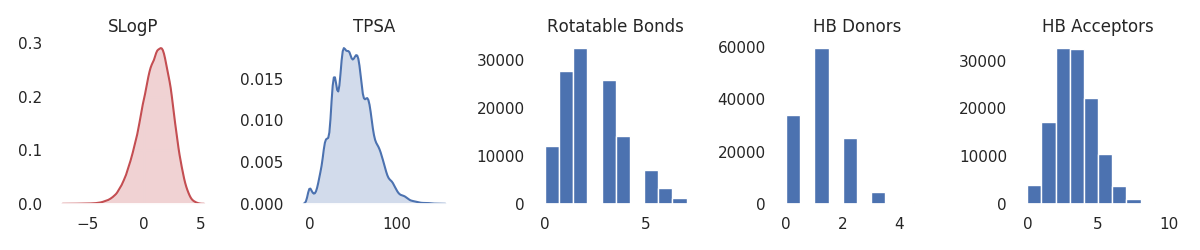

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
plt.close()
fig = plt.figure(figsize=(12,2.5))
plt.subplot(1,5,1)
ax = sns.kdeplot(slogp['SLogP'].tolist(), shade=True, color="r")
ax.set_title('SLogP')
plt.subplot(1,5,2)
ax = sns.kdeplot(psa, shade=True, color="b")
ax.set_title('TPSA')
plt.subplot(1,5,3)
plt.hist(rb)
plt.title('Rotatable Bonds')
plt.subplot(1,5,4)
plt.hist(hbd)
plt.title('HB Donors')
plt.subplot(1,5,5)
plt.hist(hba)
plt.title('HB Acceptors')
plt.tight_layout()
display(plt.show())

In [10]:
zinc_13t09_clean = [Chem.MolToSmiles(s.standardize(mol), canonical = True) for mol in mols]

In [11]:
print(full_internal['Isomeric_canon'].str.contains('@').any())
print(any('@' in smi for smi in zinc_13t09_clean))

True
True

In [12]:
filt_13t09 = pd.read_csv(os.path.join(PARENT_DIR,'13_t90_exPAINS.csv'))

In [13]:
filt_13t09 = filt_13t09[filt_13t09.FILTER=='OK']

Preprocessing

In [15]:
from icml18_jtnn.fast_jtnn.mol_tree import *
cset = set()
for line in full_internal['Isomeric_canon']:
    #smiles = line.split()[0]
    mol = MolTree(line)
    for c in mol.nodes:
        cset.add(c.smiles)
print(len(cset))

87

In [16]:
zinc_13t09_clean = [Chem.MolToSmiles(s.standardize(Chem.MolFromSmiles(smi)), canonical = True) for smi in zinc_13t09_clean]

In [17]:
filt_13t09.SMILES = [Chem.MolToSmiles(s.standardize(Chem.MolFromSmiles(smi)), canonical = True) for smi in filt_13t09.SMILES]

In [18]:
pickle.dump(zinc_13t09_clean, open(os.path.join(PICKLES_DIR,'13t09_clean.p'),'wb'))
pickle.dump(filt_13t09.SMILES.tolist(), open(os.path.join(PICKLES_DIR,'13t09_filt.p'),'wb'))

In [19]:
import pickle 
len(pickle.load(open(os.path.join(PICKLES_DIR,'13t09_filt.p'),'rb')))

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3211997084194649> in <module> () 
 1 import pickle
 ----> 2 len ( pickle . load ( open ( os . path . join ( PICKLES_DIR , '13t09_filt.p' ) , 'rb' ) ) ) 

 NameError : name 'os' is not defined

In [20]:
# vocab for full_internal + ZINC_13t09
#from IPython import display
from icml18_jtnn.fast_jtnn.mol_tree import *
cset = set()
size = len(full_internal['Isomeric_canon'].tolist()+zinc_13t09_clean)
for i, line in enumerate(full_internal['Isomeric_canon'].tolist()+zinc_13t09_clean):
    #print(i,'/',size)
    #display.clear_output(wait=True)
    #smiles = line.split()[0]
    mol = MolTree(line)
    for c in mol.nodes:
        cset.add(c.smiles)
pickle.dump(Vocab(list(cset)),open(os.path.join(PICKLES_DIR,'Vocab-full_internal-ZINC_13t09.p'),'wb'))

In [21]:
# vocab for full_internal + ZINC_13t09_filtered
#from IPython import display
from icml18_jtnn.fast_jtnn.mol_tree import *
cset = set()
size = len(full_internal['Isomeric_canon'].tolist()+filt_13t09.SMILES.tolist())
for i, line in enumerate(full_internal['Isomeric_canon'].tolist()+filt_13t09.SMILES.tolist()):
    #print(i,'/',size)
    #display.clear_output(wait=True)
    #smiles = line.split()[0]
    mol = MolTree(line)
    for c in mol.nodes:
        cset.add(c.smiles)
print(len(cset))
pickle.dump(Vocab(list(cset)),open(os.path.join(PICKLES_DIR,'Vocab-full_internal-ZINC_13t09_filt.p'),'wb'))

629

In [22]:
with open('/dbfs/FileStore/ZINC/13t09_clean.txt', 'w+') as f:
  f.write('\n'.join(zinc_13t09_clean))
  f.close()
filt_13t09.filter(['SMILES']).to_csv('/dbfs/FileStore/ZINC/13t09_filt.txt',header=None,index=False)

In [23]:
%sh head /dbfs/FileStore/ZINC/13t09_filt.txt

Cc1n[n-]c(C(F)(F)F)n1
[O-]c1cc([O-])n2nncc2n1
[O-]c1cc([O-])n2ncnc2n1
Cc1cc(C(F)(F)F)co1
Cc1ccc(C(F)(F)F)o1
Cc1ncc(C(F)(F)F)[nH]1
Cc1[nH]cnc1C(F)(F)F
Cc1c[nH]nc1C(F)(F)F
Cn1nccc1C(F)(F)F
FC(F)(F)Cc1c[nH]cn1

In [24]:
def train_prop(model, lr, beta, batch_size, MAX_EPOCH, SAVE_DIR, SMILES_DIR, PROP_DIR, pretrain=True, model_path=None, PRINT_ITER=20, last_epoch = 0, log_file=None):
    if pretrain:
        for param in model.parameters():
            if param.dim() == 1:
                nn.init.constant(param, 0)
            else:
                nn.init.xavier_normal(param)
    else:
        model.load_state_dict(torch.load(model_path))
    model = model.cuda()
    print( "Model #Params: %dK" % (sum([x.nelement() for x in model.parameters()]) / 1000,))

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ExponentialLR(optimizer, 0.9)
    scheduler.step()

    dataset = PropDataset(SMILES_DIR, PROP_DIR)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x:x)

    if log_file:
        of_connection = open(out_file, 'w')
        writer = csv.writer(of_connection)

        # Write the headers to the file
        writer.writerow(['loss', 'kl_div', 'wacc', 'tacc', 'sacc', 'dacc', 'word_acc', 'topo_acc', 'assm_acc', 'steo_acc'])
    #MAX_EPOCH = int(3)
    #PRINT_ITER = 20

    for epoch in range(MAX_EPOCH):
        word_acc,topo_acc,assm_acc,steo_acc,prop_acc = 0,0,0,0,0

        for it, batch in enumerate(dataloader):
            for mol_tree,_ in batch:
                for node in mol_tree.nodes:
                    if node.label not in node.cands:
                        node.cands.append(node.label)
                        node.cand_mols.append(node.label_mol)

            model.zero_grad()
            loss, kl_div, wacc, tacc, sacc, dacc, pacc = model(batch, beta=beta)
            loss.backward()
            optimizer.step()

            word_acc += wacc
            topo_acc += tacc
            assm_acc += sacc
            steo_acc += dacc
            prop_acc += pacc
            writer.writerow([loss, kl_div, wacc, tacc, sacc, dacc, word_acc, topo_acc, assm_acc, steo_acc])
            if (it + 1) % PRINT_ITER == 0:
                word_acc = word_acc / PRINT_ITER * 100
                topo_acc = topo_acc / PRINT_ITER * 100
                assm_acc = assm_acc / PRINT_ITER * 100
                steo_acc = steo_acc / PRINT_ITER * 100
                prop_acc = prop_acc / PRINT_ITER

                print("KL: %.1f, Word: %.2f, Topo: %.2f, Assm: %.2f, Steo: %.2f, Prop: %.4f" % (kl_div, word_acc, topo_acc, assm_acc, steo_acc, prop_acc))
                word_acc,topo_acc,assm_acc,steo_acc,prop_acc = 0,0,0,0,0
                sys.stdout.flush()

        scheduler.step()
        print( "learning rate: %.6f" % scheduler.get_lr()[0])
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)
        savename = "/prop_model.iter-"
        if pretrain:
            savename = "/pretrain_KL-prop_model.iter-"
        torch.save(model.state_dict(), SAVE_DIR + savename + str(epoch+last_epoch))
        print('\nModel saved to: ',SAVE_DIR + savename + str(epoch+last_epoch))
    of_connection.close()

In [25]:
def train_vae(model, lr, beta, batch_size, MAX_EPOCH, SAVE_DIR, SMILES_DIR, pretrain=True, model_load=None, PRINT_ITER=20, last_epoch = 0, log_file=None):
    if pretrain:
        for param in model.parameters():
            if param.dim() == 1:
                nn.init.constant(param, 0)
            else:
                nn.init.xavier_normal(param)
    else:
        model.load_state_dict(torch.load(model_load))
    model = model.cuda()
    print( "Model #Params: %dK" % (sum([x.nelement() for x in model.parameters()]) / 1000,))

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.ExponentialLR(optimizer, 0.9)
    scheduler.step()
    log_df = []
    dataset = MoleculeDataset(SMILES_DIR)
    last_epoch+=1
    if log_file:
        of_connection = open(out_file, 'w')
        writer = csv.writer(of_connection)

        # Write the headers to the file
        writer.writerow(['loss', 'kl_div', 'wacc', 'tacc', 'sacc', 'dacc', 'word_acc', 'topo_acc', 'assm_acc', 'steo_acc'])
    #MAX_EPOCH = int(3)
    #PRINT_ITER = 20

    for epoch in range(MAX_EPOCH):
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x:x, 
                                drop_last=True)
        
        word_acc,topo_acc,assm_acc,steo_acc= 0,0,0,0

        for it, batch in enumerate(dataloader):
            for mol_tree in batch:
                for node in mol_tree.nodes:
                    if node.label not in node.cands:
                        node.cands.append(node.label)
                        node.cand_mols.append(node.label_mol)

            model.zero_grad()
            loss, kl_div, wacc, tacc, sacc, dacc = model(batch, beta=beta)
            loss.backward()
            optimizer.step()
            
            word_acc += wacc
            topo_acc += tacc
            assm_acc += sacc
            steo_acc += dacc
            #prop_acc += pacc
            
            
            writer.writerow([loss, kl_div, wacc, tacc, sacc, dacc, word_acc, topo_acc, assm_acc, steo_acc])
            
            if (it + 1) % PRINT_ITER == 0:
                word_acc = word_acc / PRINT_ITER * 100
                topo_acc = topo_acc / PRINT_ITER * 100
                assm_acc = assm_acc / PRINT_ITER * 100
                steo_acc = steo_acc / PRINT_ITER * 100
                #prop_acc = prop_acc / PRINT_ITER

                print("KL: %.1f, Word: %.2f, Topo: %.2f, Assm: %.2f, Steo: %.2f" % 
                      (kl_div, word_acc, topo_acc, assm_acc, steo_acc))
                word_acc,topo_acc,assm_acc,steo_acc = 0,0,0,0
                sys.stdout.flush()
    
        scheduler.step()
        print( "learning rate: %.6f" % scheduler.get_lr()[0])
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)
        savename = "/vae_model.iter-"
        if pretrain:
            savename = "/pretrain-vae_model.iter-"
        torch.save(model.state_dict(), SAVE_DIR + savename + str(epoch+last_epoch))
        print('Model saved to: ',SAVE_DIR + savename + str(epoch+last_epoch)+'\n')
    of_connection.close()

# Pretrain

In [27]:
vocab = pickle.load(open(os.path.join(PICKLES_DIR,'Vocab-full_internal-ZINC_13t09.p'),'rb'))

weight_dir = os.path.join(MODEL_DIR,'13t09_clean')
if not os.path.exists(weight_dir):
  os.mkdir(weight_dir)
out_file = os.path.join(weight_dir,'pretrain_log-13t09_clean.csv')

batch_size = int(40)
hidden_size = int(420)
latent_size = int(56)
depth = int(3)
beta = 0.0
lr = 1e-3

model = JTNNVAE(vocab, hidden_size, latent_size, depth)

train_vae(model=model, 
          lr=lr, 
          beta=beta, 
          batch_size=batch_size, 
          MAX_EPOCH=30, 
          SAVE_DIR=weight_dir, 
          SMILES_DIR='/dbfs/FileStore/ZINC/13t09_clean.txt', 
          pretrain=True, 
          PRINT_ITER=20,
          log_file=out_file)

In [28]:
vocab = pickle.load(open(os.path.join(PICKLES_DIR,'Vocab-full_internal-ZINC_13t09_filt.p'),'rb'))

weight_dir = os.path.join(MODEL_DIR,'13t09_filt')
if not os.path.exists(weight_dir):
  os.mkdir(weight_dir)
out_file = os.path.join(weight_dir,'pretrain_log-13t09_filt.csv')

batch_size = int(40)
hidden_size = int(420)
latent_size = int(56)
depth = int(3)
beta = 0.0
lr = 1e-3

model = JTNNVAE(vocab, hidden_size, latent_size, depth)

train_vae(model=model, 
          lr=lr, 
          beta=beta, 
          batch_size=batch_size, 
          MAX_EPOCH=30, 
          SAVE_DIR=weight_dir, 
          SMILES_DIR='/dbfs/FileStore/ZINC/13t09_filt.txt', 
          pretrain=True, 
          PRINT_ITER=20,
          log_file=out_file)

/databricks/python/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
 warnings.warn(warning.format(ret))
/local_disk0/tmp/1556727629545-0/PythonShell.py:7: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
 import pickle
/local_disk0/tmp/1556727629545-0/PythonShell.py:5: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
 import linecache
Model #Params: 4377K
/local_disk0/spark-de16ad5c-8f36-432f-99f8-154216fd263f/userFiles-7c134309-84ad-48bf-9f1a-7ad652c1b0dc/addedFile6234755862196679065dbfs__FileStore_jars_23c5a07d_a093_423e_97a9_a303ec5f6ff5_icml18_jtnn_0_1_py3_7_3fd5e-93fb9.egg/icml18_jtnn/jtnn/jtnn_vae.py:166: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
KL: 117.9, Word: 20.10, Topo: 72.51, Assm: 48.36, Steo: 62.50
KL: 128.8, Word: 26.49, Topo: 86.32, Assm: 52.89, Steo: 56.67
KL: 155.9, Word: 29.46, Topo: 90.19, Assm: 53.40, Steo: 57.50
KL: 174.1, Word: 37.48, Topo: 90.64, Assm: 51.91, Steo: 60.83
KL: 197.4, Word: 44.16, Topo: 92.10, Assm: 51.62, Steo: 77.92
KL: 235.5, Word: 48.18, Topo: 93.93, Assm: 53.67, Steo: 75.00
KL: 213.6, Word: 53.57, Topo: 93.99, Assm: 52.63, Steo: 71.25
KL: 256.0, Word: 54.58, Topo: 94.30, Assm: 56.59, Steo: 72.50
KL: 297.9, Word: 58.84, Topo: 95.13, Assm: 56.15, Steo: 74.17
KL: 285.4, Word: 60.56, Topo: 94.73, Assm: 58.14, Steo: 82.50
KL: 335.5, Word: 61.69, Topo: 95.47, Assm: 60.43, Steo: 97.50
KL: 311.3, Word: 63.15, Topo: 95.56, Assm: 59.30, Steo: 95.00
KL: 363.7, Word: 64.63, Topo: 95.44, Assm: 60.25, Steo: 100.00
KL: 376.7, Word: 65.34, Topo: 96.26, Assm: 57.36, Steo: 100.00
KL: 479.5, Word: 65.60, Topo: 96.47, Assm: 62.03, Steo: 98.33
KL: 387.5, Word: 67.38, Topo: 96.50, Assm: 62.08, Steo: 100.00
KL: 444.3, Word: 68.48, Topo: 96.51, Assm: 64.55, Steo: 95.00
KL: 460.8, Word: 69.60, Topo: 94.46, Assm: 66.33, Steo: 92.50
KL: 469.4, Word: 70.94, Topo: 94.79, Assm: 64.70, Steo: 100.00
KL: 450.0, Word: 71.19, Topo: 96.11, Assm: 63.13, Steo: 98.33
KL: 459.5, Word: 73.30, Topo: 96.53, Assm: 63.64, Steo: 100.00
KL: 517.9, Word: 72.98, Topo: 97.03, Assm: 65.44, Steo: 100.00
KL: 472.6, Word: 73.03, Topo: 96.00, Assm: 66.10, Steo: 100.00
KL: 444.4, Word: 73.61, Topo: 96.32, Assm: 66.10, Steo: 100.00
KL: 498.7, Word: 74.83, Topo: 96.54, Assm: 67.80, Steo: 100.00
KL: 508.4, Word: 75.70, Topo: 96.88, Assm: 65.94, Steo: 100.00
KL: 496.5, Word: 76.27, Topo: 97.11, Assm: 66.64, Steo: 100.00
KL: 502.1, Word: 76.97, Topo: 97.00, Assm: 66.91, Steo: 100.00
KL: 558.0, Word: 78.30, Topo: 96.73, Assm: 67.05, Steo: 100.00
KL: 569.5, Word: 78.36, Topo: 97.68, Assm: 69.81, Steo: 100.00
KL: 633.8, Word: 78.87, Topo: 97.49, Assm: 68.63, Steo: 100.00
KL: 611.6, Word: 79.14, Topo: 97.44, Assm: 70.02, Steo: 100.00
KL: 570.3, Word: 79.13, Topo: 96.74, Assm: 69.32, Steo: 100.00
KL: 591.8, Word: 78.84, Topo: 97.86, Assm: 70.08, Steo: 100.00
KL: 593.8, Word: 79.40, Topo: 97.26, Assm: 70.38, Steo: 100.00
KL: 645.1, Word: 80.33, Topo: 97.28, Assm: 69.78, Steo: 95.00
KL: 614.9, Word: 80.64, Topo: 97.14, Assm: 69.72, Steo: 95.00
KL: 663.9, Word: 80.48, Topo: 97.31, Assm: 68.59, Steo: 100.00
KL: 576.4, Word: 81.14, Topo: 97.77, Assm: 70.53, Steo: 100.00
KL: 649.0, Word: 82.97, Topo: 97.33, Assm: 70.98, Steo: 100.00
KL: 635.5, Word: 83.10, Topo: 97.44, Assm: 72.11, Steo: 100.00
KL: 664.6, Word: 82.85, Topo: 97.49, Assm: 72.65, Steo: 100.00
KL: 708.4, Word: 83.63, Topo: 97.75, Assm: 70.16, Steo: 100.00
KL: 645.4, Word: 84.29, Topo: 97.58, Assm: 69.40, Steo: 100.00
KL: 639.7, Word: 84.47, Topo: 97.95, Assm: 72.13, Steo: 100.00
KL: 686.1, Word: 84.18, Topo: 97.55, Assm: 71.32, Steo: 100.00
KL: 701.8, Word: 83.34, Topo: 97.90, Assm: 73.53, Steo: 100.00
KL: 699.0, Word: 85.25, Topo: 97.92, Assm: 74.65, Steo: 100.00
KL: 671.8, Word: 84.95, Topo: 97.98, Assm: 71.38, Steo

Out[9]: '/dbfs/FileStore/pickles/jtvae_model/13t09_filt'

# Train w/ KL regularization

In [31]:
%sh ls /dbfs/FileStore/tables/JAK*

/dbfs/FileStore/tables/JAK1_20190311_cids.csv
/dbfs/FileStore/tables/JAK1_20190311.csv
/dbfs/FileStore/tables/JAK1_20190311_sdf-d4409.gz
/dbfs/FileStore/tables/JAK1 EC50 nM 1027-full.txt
/dbfs/FileStore/tables/JAK1 EC50 nM 1027.txt
/dbfs/FileStore/tables/JAK1 EC50 nM 1027-y_test.txt
/dbfs/FileStore/tables/JAK1 EC50 nM 1027-y_train.txt
/dbfs/FileStore/tables/JAK2_20190311.csv
/dbfs/FileStore/tables/JAK2_20190311_sdf-3d49e.gz
/dbfs/FileStore/tables/JAK2 EC50 nM 1024-full.txt
/dbfs/FileStore/tables/JAK2 EC50 nM 1024.txt
/dbfs/FileStore/tables/JAK2 EC50 nM 1024-y_test.txt
/dbfs/FileStore/tables/JAK2 EC50 nM 1024-y_train.txt
/dbfs/FileStore/tables/JAK3_20190311.csv
/dbfs/FileStore/tables/JAK3_20190311_sdf-08df5.gz
/dbfs/FileStore/tables/JAK3 EC50 nM 1026-full.txt
/dbfs/FileStore/tables/JAK3 EC50 nM 1026.txt
/dbfs/FileStore/tables/JAK3 EC50 nM 1026-y_test.txt
/dbfs/FileStore/tables/JAK3 EC50 nM 1026-y_train.txt

In [32]:
%sh head /dbfs/FileStore/tables/X_train_smiles.txt #Cc1c[nH]c(C(=O)N2CCCN(c3ncnc4[nH]ccc34)CC23CC3)c1

Cc1c[nH]c(C(=O)N2CCCN(c3ncnc4[nH]ccc34)CC23CC3)c1
O=S(=O)(N(CCN1CCOCC1)C1CCC1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CN(C[C@@H]1CCCN1S(C)(=O)=O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CC(=O)N1CC[C@H]1COC(=O)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2
N#Cc1ccc(CC(=O)N2CCN(c3ncnc4[nH]ccc34)C3(CC3)C2)cc1
O=C(OC1CCC(O)C1)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2
CC(C)COC(=O)N1CCC[C@@H]1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
N#CCCNC(=O)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2
C[C@@H](OC(=O)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2)c1c(F)cccc1F
CN(C[C@H]1CC(F)(F)CN1C(=O)CCO)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2

In [33]:
vocab = pickle.load(open(os.path.join(PICKLES_DIR,'Vocab-full_internal-ZINC_13t09_filt.p'),'rb'))

batch_size = int(40)
hidden_size = int(420)
latent_size = int(56)
depth = int(3)
beta = 0.005
lr = 0.0007
weight_dir = os.path.join(MODEL_DIR,'13t09_filt')

save_dir = os.path.join(weight_dir,'focused')
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
out_file = os.path.join(save_dir,'vae_log-13t09_filt.csv')

model = JTNNVAE(vocab, hidden_size, latent_size, depth)
train_vae(model=model, 
          lr=lr, 
          beta=beta, 
          batch_size=batch_size, 
          MAX_EPOCH=30, 
          SAVE_DIR=save_dir, 
          SMILES_DIR=os.path.join(PARENT_DIR,'X_train_smiles.txt'), 
          pretrain=False, 
          model_load=os.path.join(weight_dir,'pretrain-vae_model.iter-30'), 
          PRINT_ITER=20,
          log_file=out_file,
          last_epoch=30)

/databricks/python/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
 warnings.warn(warning.format(ret))
Model #Params: 4377K
/local_disk0/spark-41dad439-a6be-4357-a6a3-aea4033f8c06/userFiles-b1cf8888-098a-40dc-89af-a69600ffcaa0/addedFile8926062983386895532dbfs__FileStore_jars_23c5a07d_a093_423e_97a9_a303ec5f6ff5_icml18_jtnn_0_1_py3_7_3fd5e-93fb9.egg/icml18_jtnn/jtnn/jtnn_vae.py:166: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
KL: 1801.7, Word: 73.35, Topo: 95.88, Assm: 93.37, Steo: 100.00
learning rate: 0.000630
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-31

KL: 1077.7, Word: 92.98, Topo: 99.15, Assm: 99.06, Steo: 100.00
learning rate: 0.000567
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-32

KL: 778.5, Word: 96.35, Topo: 99.49, Assm: 99.60, Steo: 100.00
learning rate: 0.000510
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-33

KL: 552.7, Word: 97.70, Topo: 99.76, Assm: 99.57, Steo: 100.00
learning rate: 0.000459
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-34

KL: 464.8, Word: 98.24, Topo: 99.77, Assm: 99.67, Steo: 100.00
learning rate: 0.000413
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-35

KL: 474.1, Word: 98.78, Topo: 99.84, Assm: 99.62, Steo: 100.00
learning rate: 0.000372
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-36

KL: 377.1, Word: 99.00, Topo: 99.88, Assm: 99.81, Steo: 100.00
learning rate: 0.000335
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-37

KL: 382.1, Word: 99.26, Topo: 99.88, Assm: 99.93, Steo: 100.00
learning rate: 0.000301
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-38

KL: 340.4, Word: 99.37, Topo: 99.92, Assm: 99.76, Steo: 100.00
learning rate: 0.000271
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-39

KL: 347.6, Word: 99.36, Topo: 99.94, Assm: 99.88, Steo: 100.00
learning rate: 0.000244
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-40

KL: 287.7, Word: 99.54, Topo: 99.95, Assm: 99.84, Steo: 100.00
learning rate: 0.000220
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-41

KL: 303.1, Word: 99.53, Topo: 99.95, Assm: 99.93, Steo: 100.00
learning rate: 0.000198
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-42

KL: 313.9, Word: 99.60, Topo: 99.97, Assm: 99.95, Steo: 100.00
learning rate: 0.000178
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-43

KL: 292.3, Word: 99.51, Topo: 99.98, Assm: 99.93, Steo: 100.00
learning rate: 0.000160
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-44

KL: 257.5, Word: 99.53, Topo: 99.98, Assm: 99.90, Steo: 100.00
learning rate: 0.000144
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-45

KL: 227.5, Word: 99.67, Topo: 99.97, Assm: 99.93, Steo: 100.00
learning rate: 0.000130
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-46

KL: 246.9, Word: 99.80, Topo: 99.97, Assm: 99.90, Steo: 100.00
learning rate: 0.000117
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-47

KL: 250.1, Word: 99.64, Topo: 99.98, Assm: 99.88, Steo: 100.00
learning rate: 0.000105
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-48

KL: 228.2, Word: 99.70, Topo: 99.98, Assm: 99.86, Steo: 100.00
learning rate: 0.000095
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused/vae_model.iter-49

In [34]:
vocab = pickle.load(open(os.path.join(PICKLES_DIR,'Vocab-full_internal-ZINC_13t09_filt.p'),'rb'))

batch_size = int(40)
hidden_size = int(420)
latent_size = int(56)
depth = int(3)
beta = 0.01
lr = 0.0007
weight_dir = os.path.join(MODEL_DIR,'13t09_filt')

save_dir = os.path.join(weight_dir,'focused_b001')
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
out_file = os.path.join(save_dir,'vae_log-13t09_filt.csv')

model = JTNNVAE(vocab, hidden_size, latent_size, depth)
train_vae(model=model, 
          lr=lr, 
          beta=beta, 
          batch_size=batch_size, 
          MAX_EPOCH=30, 
          SAVE_DIR=save_dir, 
          SMILES_DIR=os.path.join(PARENT_DIR,'X_train_smiles.txt'), 
          pretrain=False, 
          model_load=os.path.join(weight_dir,'pretrain-vae_model.iter-30'), 
          PRINT_ITER=20,
          log_file=out_file,
          last_epoch=30)

/databricks/python/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
 warnings.warn(warning.format(ret))
Model #Params: 4377K
/local_disk0/spark-0e1affbf-99b0-4288-a9e5-c37f4c8c2f7c/userFiles-df225366-cfbb-4df8-8c09-aefd7bf68229/addedFile7677603073080092539dbfs__FileStore_jars_23c5a07d_a093_423e_97a9_a303ec5f6ff5_icml18_jtnn_0_1_py3_7_3fd5e-93fb9.egg/icml18_jtnn/jtnn/jtnn_vae.py:166: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
KL: 1720.3, Word: 72.09, Topo: 95.75, Assm: 93.17, Steo: 100.00
learning rate: 0.000630
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused_b001/vae_model.iter-31

KL: 831.3, Word: 91.82, Topo: 99.23, Assm: 98.53, Steo: 99.67
learning rate: 0.000567
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused_b001/vae_model.iter-32

KL: 572.1, Word: 95.72, Topo: 99.51, Assm: 99.13, Steo: 100.00
learning rate: 0.000510
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused_b001/vae_model.iter-33

KL: 414.3, Word: 97.45, Topo: 99.64, Assm: 99.57, Steo: 100.00
learning rate: 0.000459
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused_b001/vae_model.iter-34

KL: 350.7, Word: 97.84, Topo: 99.72, Assm: 99.46, Steo: 100.00
learning rate: 0.000413
Model saved to: /dbfs/FileStore/pickles/jtvae_model/13t09_filt/focused_b001/vae_model.iter-35

In [35]:
vocab = Vocab(list(cset))

batch_size = int(40)
hidden_size = int(420)
latent_size = int(56)
depth = int(3)
beta = 0.005
lr = 0.0007

model = JTNNVAE(vocab, hidden_size, latent_size, depth)
#os.mkdir(os.path.join(MODEL_DIR,'E30E30'))
train_vae(model=model, 
          lr=lr, 
          beta=beta, 
          batch_size=batch_size, 
          MAX_EPOCH=30, 
          SAVE_DIR=os.path.join(MODEL_DIR,'E30E90'), 
          SMILES_DIR=os.path.join(PARENT_DIR,'X_train_smiles.txt'), 
          pretrain=False, 
          model_load=os.path.join(MODEL_DIR,'E30E30/vae_model.iter-59'), 
          PRINT_ITER=20,
          last_epoch=59)

Out[13]: 
['JT_VAE_generated-no_KL-30E.smi',
 'JT_VAE_generated-no_KL-E30E30.smi',
 'JT_VAE_generated.smi',
 'JT_VAE_generated.txt',
 'X_test_smiles.txt',
 'X_train_smiles.txt',
 'aae.config',
 'aae.mo_000.pt',
 'aae.mo_020.pt',
 'aae.mo_040.pt',
 'aae.mo_060.pt',
 'aae.mo_080.pt',
 'aae.model',
 'aae.vocab',
 'aae_generated.smi',
 'char_rnn.config',
 'char_rnn.mo_000.pt',
 'char_rnn.mo_020.pt',
 'char_rnn.mo_040.pt',
 'char_rnn.mo_060.pt',
 'char_rnn.mo_080.pt',
 'char_rnn.mo_100.pt',
 'char_rnn.mo_120.pt',
 'char_rnn.mo_140.pt',
 'char_rnn.mo_160.pt',
 'char_rnn.mo_180.pt',
 'char_rnn.model',
 'char_rnn.vocab',
 'char_rnn_generated.smi',
 'metrics.p',
 'metrics20190411.p',
 'organ.config',
 'organ.mo_000.pt',
 'organ.mo_020.pt',
 'organ.mo_040.pt',
 'organ.mo_060.pt',
 'organ.mo_080.pt',
 'organ.mo_100.pt',
 'organ.mo_120.pt',
 'organ.mo_140.pt',
 'organ.mo_160.pt',
 'organ.mo_180.pt',
 'organ.mo_200.pt',
 'organ.mo_220.pt',
 'organ.mo_240.pt',
 'organ.mo_260.pt',
 'organ.mo_280.pt',
 'organ.mo_300.pt',
 'organ.mo_320.pt',
 'organ.mo_340.pt',
 'organ.mo_360.pt',
 'organ.mo_380.pt',
 'organ.mo_400.pt',
 'organ.mo_420.pt',
 'organ.mo_440.pt',
 'organ.mo_460.pt',
 'organ.mo_480.pt',
 'organ.mo_500.pt',
 'organ.mo_discriminator_000.pt',
 'organ.mo_discriminator_020.pt',
 'organ.mo_discriminator_040.pt',
 'organ.mo_generator_000.pt',
 'organ.mo_generator_020.pt',
 'organ.mo_generator_040.pt',
 'organ.vocab',
 'vae.config',
 'vae.mo_000.pt',
 'vae.mo_020.pt',
 'vae.mo_040.pt',
 'vae.model',
 'vae.vocab',
 'vae_generated.smi']

In [36]:
import os
G2G = '/dbfs/FileStore/g2g'

TENSORS = os.path.join(G2G,'tensors')
dest = 'median-train_pairs'
os.listdir(os.path.join(TENSORS,dest,'JAK1'))

Out[9]: ['median-train_pairs-941-JAK1-tensors-0.pkl']

In [37]:
vocab = pickle.load(open(os.path.join(PICKLES_DIR,'Vocab-full_internal-ZINC_13t09_filt.p'),'rb'))

batch_size = int(40)
hidden_size = int(420)
latent_size = int(56)
depth = int(3)
beta = 0.005
lr = 0.0007
weight_dir = os.path.join(MODEL_DIR,'13t09_filt')

save_dir = os.path.join(weight_dir,'focused-prop')
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
out_file = os.path.join(save_dir,'vae_log-13t09_filt.csv')

model = JTNNVAE(vocab, hidden_size, latent_size, depth)
train_prop(model=model, 
          lr=lr, 
          beta=beta, 
          batch_size=batch_size, 
          MAX_EPOCH=30, 
          SAVE_DIR=save_dir, 
          SMILES_DIR=os.path.join(PARENT_DIR,'X_train_smiles.txt'), 
          PROP_DIR='/dbfs/FileStore/tables/JAK1 EC50 nM 1027-y_train.txt',
          pretrain=False, 
          model_path=os.path.join(weight_dir,'pretrain-vae_model.iter-30'), 
          PRINT_ITER=20,
          log_file=out_file,
          last_epoch=30)

--------------------------------------------------------------------------- 
 AttributeError Traceback (most recent call last)
 <command-2358522239419970> in <module> () 
 27 PRINT_ITER = 20 , 
 28 log_file = out_file , 
 ---> 29 last_epoch=30)
 
 <command-2586525794889037> in train_prop (model, lr, beta, batch_size, MAX_EPOCH, SAVE_DIR, SMILES_DIR, PROP_DIR, pretrain, model_path, PRINT_ITER, last_epoch, log_file) 
 38 
 39 model . zero_grad ( ) 
 ---> 40 loss , kl_div , wacc , tacc , sacc , dacc , pacc = model ( batch , beta = beta ) 
 41 loss . backward ( ) 
 42 optimizer . step ( ) 

 /databricks/python/lib/python3.6/site-packages/torch/nn/modules/module.py in __call__ (self, *input, **kwargs) 
 475 result = self . _slow_forward ( * input , ** kwargs ) 
 476 else : 
 --> 477 result = self . forward ( * input , ** kwargs ) 
 478 for hook in self . _forward_hooks . values ( ) : 
 479 hook_result = hook ( self , input , result ) 

 /local_disk0/spark-62a56c90-ff56-4b9b-9981-c1095d9e33aa/userFiles-bcdd8d3f-fe6c-4925-8134-e8b5e775d79f/addedFile6045101444694054779dbfs__FileStore_jars_23c5a07d_a093_423e_97a9_a303ec5f6ff5_icml18_jtnn_0_1_py3_7_3fd5e-93fb9.egg/icml18_jtnn/jtnn/jtnn_vae.py in forward (self, mol_batch, beta) 
 70 batch_size = len ( mol_batch ) 
 71 
 ---> 72 tree_mess , tree_vec , mol_vec = self . encode ( mol_batch ) 
 73 
 74 tree_mean = self . T_mean ( tree_vec ) 

 /local_disk0/spark-62a56c90-ff56-4b9b-9981-c1095d9e33aa/userFiles-bcdd8d3f-fe6c-4925-8134-e8b5e775d79f/addedFile6045101444694054779dbfs__FileStore_jars_23c5a07d_a093_423e_97a9_a303ec5f6ff5_icml18_jtnn_0_1_py3_7_3fd5e-93fb9.egg/icml18_jtnn/jtnn/jtnn_vae.py in encode (self, mol_batch) 
 49 
 50 def encode ( self , mol_batch ) : 
 ---> 51 set_batch_nodeID ( mol_batch , self . vocab ) 
 52 root_batch = [ mol_tree . nodes [ 0 ] for mol_tree in mol_batch ] 
 53 tree_mess , tree_vec = self . jtnn ( root_batch ) 

 /local_disk0/spark-62a56c90-ff56-4b9b-9981-c1095d9e33aa/userFiles-bcdd8d3f-fe6c-4925-8134-e8b5e775d79f/addedFile6045101444694054779dbfs__FileStore_jars_23c5a07d_a093_423e_97a9_a303ec5f6ff5_icml18_jtnn_0_1_py3_7_3fd5e-93fb9.egg/icml18_jtnn/jtnn/jtnn_vae.py in set_batch_nodeID (mol_batch, vocab) 
 18 tot = 0 
 19 for mol_tree in mol_batch : 
 ---> 20 for node in mol_tree . nodes : 
 21 node . idx = tot
 22 node . wid = vocab . get_index ( node . smiles ) 

 AttributeError : 'tuple' object has no attribute 'nodes'

# Generation

In [40]:
pd.Series(X_train).str.contains('@').any()

Out[13]: True

In [41]:
from icml18_jtnn.jtnn import *
vocab = Vocab(list(cset))

hidden_size = int(420)
latent_size = int(56)
depth = int(3)
nsample = int(500)
#stereo=False

model = JTNNVAE(vocab, hidden_size, latent_size, depth)#, stereo=stereo
load_dict = torch.load(os.path.join(MODEL_DIR,'E30E90/vae_model.iter-89'))
missing = {k: v for k, v in model.state_dict().items() if k not in load_dict}
load_dict.update(missing) 
model.load_state_dict(load_dict)
model = model.cuda()

/databricks/python/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
 warnings.warn(warning.format(ret))

In [42]:
torch.manual_seed(1)
gen_mols = []
for i in range(nsample):
  new_smi = model.sample_prior()#prob_decode=False
  print(new_smi)
  gen_mols.append(new_smi)

--------------------------------------------------------------------------- 
 IndexError Traceback (most recent call last)
 <command-1253470162612490> in <module> () 
 2 gen_mols = [ ] 
 3 for i in range ( nsample ) : 
 ----> 4 new_smi = model . sample_prior ( ) #prob_decode=False 
 5 print ( new_smi ) 
 6 gen_mols . append ( new_smi ) 

 /local_disk0/spark-5fe59e76-d66f-48b1-b5b6-e83803aad525/userFiles-52245eb6-9608-4fb4-8479-d240d40f4677/addedFile731834288441370575dbfs__FileStore_jars_23c5a07d_a093_423e_97a9_a303ec5f6ff5_icml18_jtnn_0_1_py3_7_3fd5e-93fb9.egg/icml18_jtnn/jtnn/jtnn_vae.py in sample_prior (self, prob_decode) 
 213 tree_vec = create_var ( torch . randn ( 1 , self . latent_size // 2 ) , False ) 
 214 mol_vec = create_var ( torch . randn ( 1 , self . latent_size // 2 ) , False ) 
 --> 215 return self . decode ( tree_vec , mol_vec , prob_decode ) 
 216 
 217 def sample_eval ( self ) : 

 /local_disk0/spark-5fe59e76-d66f-48b1-b5b6-e83803aad525/userFiles-52245eb6-9608-4fb4-8479-d240d40f4677/addedFile731834288441370575dbfs__FileStore_jars_23c5a07d_a093_423e_97a9_a303ec5f6ff5_icml18_jtnn_0_1_py3_7_3fd5e-93fb9.egg/icml18_jtnn/jtnn/jtnn_vae.py in decode (self, tree_vec, mol_vec, prob_decode) 
 259 scores = nn . CosineSimilarity ( ) ( stereo_vecs , mol_vec ) 
 260 _ , max_id = scores . max ( dim = 0 ) 
 --> 261 return stereo_cands [ max_id . data [ 0 ] ] 
 262 
 263 def dfs_assemble ( self , tree_mess , mol_vec , all_nodes , cur_mol , global_amap , fa_amap , cur_node , fa_node , prob_decode ) : 

 IndexError : invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

In [43]:
MOSES_DIR = '/dbfs/FileStore/moses'
#pd.DataFrame({name:pd.read_csv(os.path.join(MOSES_DIR,name+'_generated.smi'),squeeze=True) for name in names})
pd.DataFrame({'SMILES':gen_mols}).to_csv(os.path.join(MOSES_DIR,'JT_VAE_generated-no_KL-E30E30.smi'), index=False)

In [44]:
vocab = pickle.load(open(os.path.join(PICKLES_DIR,'Vocab-full_internal-ZINC_13t09_filt.p'),'rb'))

batch_size = int(40)
hidden_size = int(420)
latent_size = int(56)
depth = int(3)
nsample=int(500)
model = JTNNVAE(vocab, hidden_size, latent_size, depth)
load_dict = torch.load(os.path.join(weight_dir,'focused/vae_model.iter-60'))
missing = {k: v for k, v in model.state_dict().items() if k not in load_dict}
load_dict.update(missing) 
model.load_state_dict(load_dict)
model = model.cuda()
torch.manual_seed(1)
gen_mols = []
for i in range(nsample):
  new_smi = model.sample_prior()#prob_decode=False
  print(new_smi)
  gen_mols.append(new_smi)


--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1253470162612493> in <module> () 
 18 print ( new_smi ) 
 19 gen_mols . append ( new_smi ) 
 ---> 20 pd . DataFrame ( { 'SMILES' : gen_mols } ) . to_csv ( os . path . join ( MOSES_DIR , 'JT_VAE_generated-pretrain_filt-focused-E30E30.smi' ) , index = False ) 

 NameError : name 'MOSES_DIR' is not defined

In [45]:
pd.DataFrame({'SMILES':gen_mols}).to_csv(os.path.join(MOSES_DIR,'JT_VAE_generated-pretrain_filt-focused-E30E30.smi'), index=False)

# Bayesian Optimization

# Constrained Molecule Optimization - Training

In [49]:
 train_prop(model, lr, beta, batch_size, MAX_EPOCH, MODEL_DIR, SMILES_DIR, PROP_DIR, pretrain=True, model_path=None, PRINT_ITER=20)

In [50]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import math, random, sys
from optparse import OptionParser
from collections import deque

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Descriptors
from icml18_jtnn.molopt import sascorer

from icml18_jtnn.jtnn import *

In [51]:
import timeit
def timer(start, ind, obj):
    stop = timeit.default_timer()
    if (ind/len(obj)*100) < 5:
        expected_time = "Calculating..."
    else:
        time_perc = timeit.default_timer()
        expected_time = np.round(((time_perc-start)/(ind/len(obj)))/60,2)
    print("Current progress:",np.round(ind/len(obj)*100,2),"%")
    print("Current run time:",np.round((stop-start)/60,2),"minutes")
    print("Expected Run Time:",expected_time,"minutes")

In [52]:
vocab = Vocab(list(cset))
hidden_size = int(420)
latent_size = int(56)
depth = int(3)
sim_cutoff = 0.0
model = JTPropVAE(vocab, hidden_size, latent_size, depth)
model.load_state_dict(torch.load('/dbfs/FileStore/pickles/jtvae_model/JAK1 EC50 nM 1027/prop_model.iter-5'))
model = model.cuda()
res = []
import GPUtil
from IPython.display import clear_output

start = timeit.default_timer()

for i, smiles in enumerate(X_test):
    mol = Chem.MolFromSmiles(smiles)
    #score = Descriptors.MolLogP(mol) - sascorer.calculateScore(mol, path_to_fpscores=os.path.join(PARENT_DIR,'fpscores_pkl.gz'))
    print(i)
    new_smiles,sim = model.optimize(smiles, sim_cutoff=sim_cutoff, lr=2, num_iter=80)
    new_mol = Chem.MolFromSmiles(new_smiles)
    #new_score = Descriptors.MolLogP(new_mol) - sascorer.calculateScore(new_mol,path_to_fpscores=os.path.join(PARENT_DIR,'fpscores_pkl.gz'))
    #GPUtil.showUtilization()
    clear_output(wait=True)

    timer(start, i, X_test)
    #res.append( (new_score - score, sim, score, new_score, smiles, new_smiles) )
    #print(new_score - score, sim, score, new_score, smiles, new_smiles)
    res.append(new_smiles)

#print(sum([x[0] for x in res]), sum([x[1] for x in res]))


In [53]:
len(X_test)

Out[13]: 365

In [56]:

#vocab = [x.strip("\r\n ") for x in open(opts.vocab_path)] 
vocab = Vocab(list(cset))

batch_size = int(40)
hidden_size = int(420)
latent_size = int(56)
depth = int(3)

model = JTPropVAE(vocab, hidden_size, latent_size, depth)

for param in model.parameters():
    if param.dim() == 1:
        nn.init.constant(param, 0)
    else:
        nn.init.xavier_normal(param)

model = model.cuda()
print( "Model #Params: %dK" % (sum([x.nelement() for x in model.parameters()]) / 1000,))

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.ExponentialLR(optimizer, 0.9)
scheduler.step()

dataset = PropDataset(os.path.join(PARENT_DIR,'full_smiles.txt'), os.path.join(PARENT_DIR,names[0]+'.txt'))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x:x)

MAX_EPOCH = int(3)
PRINT_ITER = 20

for epoch in range(MAX_EPOCH):
    word_acc,topo_acc,assm_acc,steo_acc,prop_acc = 0,0,0,0,0

    for it, batch in enumerate(dataloader):
        for mol_tree,_ in batch:
            for node in mol_tree.nodes:
                if node.label not in node.cands:
                    node.cands.append(node.label)
                    node.cand_mols.append(node.label_mol)

        model.zero_grad()
        loss, kl_div, wacc, tacc, sacc, dacc, pacc = model(batch, beta=0)
        loss.backward()
        optimizer.step()

        word_acc += wacc
        topo_acc += tacc
        assm_acc += sacc
        steo_acc += dacc
        prop_acc += pacc

        if (it + 1) % PRINT_ITER == 0:
            word_acc = word_acc / PRINT_ITER * 100
            topo_acc = topo_acc / PRINT_ITER * 100
            assm_acc = assm_acc / PRINT_ITER * 100
            steo_acc = steo_acc / PRINT_ITER * 100
            prop_acc = prop_acc / PRINT_ITER

            print("KL: %.1f, Word: %.2f, Topo: %.2f, Assm: %.2f, Steo: %.2f, Prop: %.4f" % (kl_div, word_acc, topo_acc, assm_acc, steo_acc, prop_acc))
            word_acc,topo_acc,assm_acc,steo_acc,prop_acc = 0,0,0,0,0
            sys.stdout.flush()

    scheduler.step()
    print( "learning rate: %.6f" % scheduler.get_lr()[0])
    torch.save(model.state_dict(), MODEL_DIR + "/model.iter-" + str(epoch))

/databricks/python/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
 warnings.warn(warning.format(ret))
/local_disk0/tmp/1553963390297-0/PythonShell.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
 from collections import OrderedDict
/local_disk0/tmp/1553963390297-0/PythonShell.py:14: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
 import traceback
Model #Params: 3946K
/local_disk0/spark-a376ed6f-69b7-4b67-a8b6-ad6533452811/userFiles-945a78dc-e7a7-4b49-94ef-db7ed43d9f4a/addedFile6238721892749691038dbfs__FileStore_jars_ba628ba6_8186_4e38_ab41_1e8a42751426_icml18_jtnn_0_1_py3_7_3fd5e-6964d.egg/icml18_jtnn/jtnn/jtprop_vae.py:134: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/local_disk0/spark-a376ed6f-69b7-4b67-a8b6-ad6533452811/userFiles-945a78dc-e7a7-4b49-94ef-db7ed43d9f4a/addedFile6238721892749691038dbfs__FileStore_jars_ba628ba6_8186_4e38_ab41_1e8a42751426_icml18_jtnn_0_1_py3_7_3fd5e-6964d.egg/icml18_jtnn/jtnn/jtprop_vae.py:168: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/local_disk0/spark-a376ed6f-69b7-4b67-a8b6-ad6533452811/userFiles-945a78dc-e7a7-4b49-94ef-db7ed43d9f4a/addedFile6238721892749691038dbfs__FileStore_jars_ba628ba6_8186_4e38_ab41_1e8a42751426_icml18_jtnn_0_1_py3_7_3fd5e-6964d.egg/icml18_jtnn/jtnn/jtprop_vae.py:101: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
KL: 37620.8, Word: 22.18, Topo: 73.31, Assm: 74.06, Steo: 54.70, Prop: 42284376.0000
KL: 89176.5, Word: 45.06, Topo: 88.63, Assm: 80.86, Steo: 43.97, Prop: 26170828.0000
learning rate: 0.000900
KL: 83814.9, Word: 57.50, Topo: 94.04, Assm: 84.79, Steo: 48.30, Prop: 38363532.0000
KL: 73418.0, Word: 65.03, Topo: 95.40, Assm: 85.70, Steo: 47.59, Prop: 36652696.0000
learning rate: 0.000810
KL: 48555.5, Word: 71.37, Topo: 96.14, Assm: 88.75, Steo: 54.01, Prop: 22451174.0000
KL: 32698.0, Word: 71.91, Topo: 96.23, Assm: 87.99, Steo: 55.97, Prop: 34842292.0000

In [57]:
beta = 0.005
lr = 0.0007

model = JTPropVAE(vocab, hidden_size, latent_size, depth)

if opts.model_path is not None:
    model.load_state_dict(torch.load(opts.model_path))
else:
    for param in model.parameters():
        if param.dim() == 1:
            nn.init.constant(param, 0)
        else:
            nn.init.xavier_normal(param)

model = model.cuda()
print( "Model #Params: %dK" % (sum([x.nelement() for x in model.parameters()]) / 1000,))

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, 0.9)
scheduler.step()

MAX_EPOCH = 6
PRINT_ITER = 20

for epoch in range(MAX_EPOCH):
    word_acc,topo_acc,assm_acc,steo_acc,prop_acc = 0,0,0,0,0

    for it, batch in enumerate(dataloader):
        for mol_tree,_ in batch:
            for node in mol_tree.nodes:
                if node.label not in node.cands:
                    node.cands.append(node.label)
                    node.cand_mols.append(node.label_mol)

        model.zero_grad()
        loss, kl_div, wacc, tacc, sacc, dacc, pacc = model(batch, beta)
        loss.backward()
        optimizer.step()

        word_acc += wacc
        topo_acc += tacc
        assm_acc += sacc
        steo_acc += dacc
        prop_acc += pacc

        if (it + 1) % PRINT_ITER == 0:
            word_acc = word_acc / PRINT_ITER * 100
            topo_acc = topo_acc / PRINT_ITER * 100
            assm_acc = assm_acc / PRINT_ITER * 100
            steo_acc = steo_acc / PRINT_ITER * 100
            prop_acc /= PRINT_ITER

            print("KL: %.1f, Word: %.2f, Topo: %.2f, Assm: %.2f, Steo: %.2f, Prop: %.4f" % (kl_div, word_acc, topo_acc, assm_acc, steo_acc, prop_acc))
            word_acc,topo_acc,assm_acc,steo_acc,prop_acc = 0,0,0,0,0
            sys.stdout.flush()

        if (it + 1) % 1500 == 0: #Fast annealing
            scheduler.step()
            print "learning rate: %.6f" % scheduler.get_lr()[0]
            torch.save(model.state_dict(), opts.save_path + "/model.iter-%d-%d" % (epoch, it + 1))

    scheduler.step()
    print("learning rate: ", scheduler.get_lr()[0])
    torch.save(model.state_dict(), MODEL_DIR + "/prop_model.iter-" + str(epoch))

Out[19]: 2.0

In [58]:
from icml18_jtnn.fast_molvae.preprocess import *

In [59]:
import torch
import torch.nn as nn
from multiprocessing import Pool

import math, random, sys
from optparse import OptionParser
import _pickle as pickle

from icml18_jtnn.fast_jtnn import *
import rdkit

def tensorize(smiles, assm=True):
    mol_tree = MolTree(smiles)
    mol_tree.recover()
    if assm:
        mol_tree.assemble()
        for node in mol_tree.nodes:
            if node.label not in node.cands:
                node.cands.append(node.label)

    del mol_tree.mol
    #for node in mol_tree.nodes:
        #del node.mol

    return mol_tree

In [60]:
PROCESSED_DIR = os.path.join(PICKLES_DIR, "jtvae_processed")
os.mkdir(PROCESSED_DIR)

--------------------------------------------------------------------------- 
 FileExistsError Traceback (most recent call last)
 <command-1531239716267171> in <module> () 
 1 PROCESSED_DIR = os . path . join ( PICKLES_DIR , "jtvae_processed" ) 
 ----> 2 os . mkdir ( PROCESSED_DIR ) 

 FileExistsError : [Errno 17] File exists: '/dbfs/FileStore/pickles/jtvae_processed'

In [61]:
pool = Pool(1)
num_splits = int(20)

data = full_internal['Isomeric_canon'].tolist()

all_data = [tensorize(x) for x in data]

le = (len(all_data) + num_splits - 1) / num_splits

for split_id in xrange(num_splits):
    st = split_id * le
    sub_data = all_data[st : st + le]

    with open(os.path.join(PROCESSED_DIR, 'tensors-%d.pkl' % split_id), 'wb') as f:
        pickle.dump(sub_data, f, pickle.HIGHEST_PROTOCOL)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1531239716267170> in <module> () 
 4 data = full_internal [ 'Isomeric_canon' ] . tolist ( ) 
 5 
 ----> 6 all_data = [ tensorize ( x ) for x in data ] 
 7 
 8 le = ( len ( all_data ) + num_splits - 1 ) / num_splits

 <command-1531239716267170> in <listcomp> (.0) 
 4 data = full_internal [ 'Isomeric_canon' ] . tolist ( ) 
 5 
 ----> 6 all_data = [ tensorize ( x ) for x in data ] 
 7 
 8 le = ( len ( all_data ) + num_splits - 1 ) / num_splits

 <command-1531239716267172> in tensorize (smiles, assm) 
 14 mol_tree . recover ( ) 
 15 if assm : 
 ---> 16 mol_tree . assemble ( ) 
 17 for node in mol_tree . nodes : 
 18 if node . label not in node . cands : 

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/mol_tree.py in assemble (self) 
 101 def assemble ( self ) : 
 102 for node in self . nodes : 
 --> 103 node . assemble ( ) 
 104 
 105 def dfs ( node , fa_idx ) : 

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/mol_tree.py in assemble (self) 
 48 neighbors = singletons + neighbors
 49 
 ---> 50 cands , aroma = enum_assemble ( self , neighbors ) 
 51 new_cands = [ cand for i , cand in enumerate ( cands ) if aroma [ i ] >= 0 ] 
 52 if len ( new_cands ) > 0 : cands = new_cands

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/chemutils.py in enum_assemble (node, neighbors, prev_nodes, prev_amap) 
 297 cand_smiles . add ( smiles ) 
 298 candidates . append ( ( smiles , amap ) ) 
 --> 299 aroma_score . append ( check_aroma ( cand_mol , node , neighbors ) ) 
 300 
 301 return candidates , aroma_score

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/chemutils.py in check_aroma (cand_mol, ctr_node, nei_nodes) 
 319 
 320 get_nid = lambda x : 0 if node . is_leaf else node . nid
 --> 321 benzynes = [ get_nid ( node ) for node in nei_nodes + [ ctr_node ] if node . smiles in Vocab . benzynes ] 
 322 penzynes = [ get_nid ( node ) for node in nei_nodes + [ ctr_node ] if node . smiles in Vocab . penzynes ] 
 323 if len ( benzynes ) + len ( penzynes ) == 0 : 

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/chemutils.py in <listcomp> (.0) 
 319 
 320 get_nid = lambda x : 0 if node . is_leaf else node . nid
 --> 321 benzynes = [ get_nid ( node ) for node in nei_nodes + [ ctr_node ] if node . smiles in Vocab . benzynes ] 
 322 penzynes = [ get_nid ( node ) for node in nei_nodes + [ ctr_node ] if node . smiles in Vocab . penzynes ] 
 323 if len ( benzynes ) + len ( penzynes ) == 0 : 

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/chemutils.py in <lambda> (x) 
 318 if len ( rings ) < 2 : return 0 #Only multi-ring system needs to be checked 
 319 
 --> 320 get_nid = lambda x : 0 if node . is_leaf else node . nid
 321 benzynes = [ g

In [62]:
mol_tree = MolTree('CN(CC1CC(F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2')
mol_tree.recover()

mol_tree.assemble()

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1531239716267173> in <module> () 
 2 mol_tree . recover ( ) 
 3 
 ----> 4 mol_tree . assemble ( ) 

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/mol_tree.py in assemble (self) 
 101 def assemble ( self ) : 
 102 for node in self . nodes : 
 --> 103 node . assemble ( ) 
 104 
 105 def dfs ( node , fa_idx ) : 

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/mol_tree.py in assemble (self) 
 48 neighbors = singletons + neighbors
 49 
 ---> 50 cands , aroma = enum_assemble ( self , neighbors ) 
 51 new_cands = [ cand for i , cand in enumerate ( cands ) if aroma [ i ] >= 0 ] 
 52 if len ( new_cands ) > 0 : cands = new_cands

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/chemutils.py in enum_assemble (node, neighbors, prev_nodes, prev_amap) 
 297 cand_smiles . add ( smiles ) 
 298 candidates . append ( ( smiles , amap ) ) 
 --> 299 aroma_score . append ( check_aroma ( cand_mol , node , neighbors ) ) 
 300 
 301 return candidates , aroma_score

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/chemutils.py in check_aroma (cand_mol, ctr_node, nei_nodes) 
 319 
 320 get_nid = lambda x : 0 if node . is_leaf else node . nid
 --> 321 benzynes = [ get_nid ( node ) for node in nei_nodes + [ ctr_node ] if node . smiles in Vocab . benzynes ] 
 322 penzynes = [ get_nid ( node ) for node in nei_nodes + [ ctr_node ] if node . smiles in Vocab . penzynes ] 
 323 if len ( benzynes ) + len ( penzynes ) == 0 : 

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/chemutils.py in <listcomp> (.0) 
 319 
 320 get_nid = lambda x : 0 if node . is_leaf else node . nid
 --> 321 benzynes = [ get_nid ( node ) for node in nei_nodes + [ ctr_node ] if node . smiles in Vocab . benzynes ] 
 322 penzynes = [ get_nid ( node ) for node in nei_nodes + [ ctr_node ] if node . smiles in Vocab . penzynes ] 
 323 if len ( benzynes ) + len ( penzynes ) == 0 : 

 /local_disk0/spark-7176e284-af06-40fc-ab93-e4b8a755b275/userFiles-e8ecb9fb-3024-4bea-a8e3-4cb2e829c1ab/addedFile3453741836193570924dbfs__FileStore_jars_b3d80b5a_617a_4ce0_81da_c4868ab12bac_icml18_jtnn_0_1_py3_7_3fd5e-aba95.egg/icml18_jtnn/fast_jtnn/chemutils.py in <lambda> (x) 
 318 if len ( rings ) < 2 : return 0 #Only multi-ring system needs to be checked 
 319 
 --> 320 get_nid = lambda x : 0 if node . is_leaf else node . nid
 321 benzynes = [ get_nid ( node ) for node in nei_nodes + [ ctr_node ] if node . smiles in Vocab . benzynes ] 
 322 penzynes = [ get_nid ( node ) for node in nei_nodes + [ ctr_node ] if node . smiles in Vocab . penzynes ] 

 NameError : name 'node' is not defined

In [63]:
from icml18_jtnn.fast_jtnn.chemutils import get_clique_mol, tree_decomp, get_mol, get_smiles, set_atommap, enum_assemble, decode_stereo

smiles = 'CN(CC1CC(F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2'

mol = get_mol(smiles)
cliques, edges = tree_decomp(mol)
for i,c in enumerate(cliques):
  cmol = get_clique_mol(mol, c)
  print(MolTreeNode(get_smiles(cmol), c))

<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f405278>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f405a90>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f405a90>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f405a90>
<icml18_jtnn.fast_jtnn.mol_tree.MolTreeNode object at 0x7fbf4f4057f0>

In [64]:
full_internal['Isomeric_canon'].str.contains('@').any()

Out[25]: False

In [65]:
%run -m icml18_jtnn.fast_jtnn.mol_tree -i 

In [66]:
%sh pip freeze

absl-py==0.6.1
asn1crypto==0.24.0
astor==0.7.1
backports-abc==0.5
backports.functools-lru-cache==1.5
backports.shutil-get-terminal-size==1.0.0
backports.weakref==1.0.post1
bcrypt==3.1.5
bleach==2.1.3
boto==2.48.0
boto3==1.7.62
botocore==1.10.62
certifi==2018.4.16
cffi==1.11.5
chardet==3.0.4
cloudpickle==0.5.3
colorama==0.3.9
configparser==3.5.0
cryptography==2.2.2
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
docutils==0.14
entrypoints==0.2.3
enum34==1.1.6
et-xmlfile==1.0.1
funcsigs==1.0.2
functools32==3.2.3.post2
fusepy==2.0.4
futures==3.2.0
gast==0.2.0
grpcio==1.12.1
h5py==2.8.0
horovod==0.15.2
html5lib==1.0.1
idna==2.6
ipaddress==1.0.22
ipython==5.7.0
ipython-genutils==0.2.0
jdcal==1.4
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter-client==5.2.3
jupyter-core==4.4.0
Keras==2.2.4
Keras-Applications==1.0.6
Keras-Preprocessing==1.0.5
kiwisolver==1.0.1
linecache2==1.0.0
llvmlite==0.23.1
lxml==4.2.1
Markdown==3.0.1
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
mleap==0.8.1
mock==2.0.0
msgpack==0.5.6
nbconvert==5.3.1
nbformat==4.4.0
nose==1.3.7
nose-exclude==0.5.0
numba==0.38.0+0.g2a2b772fc.dirty
numpy==1.14.3
olefile==0.45.1
openpyxl==2.5.3
pandas==0.23.0
pandocfilters==1.4.2
paramiko==2.4.1
pathlib2==2.3.2
patsy==0.5.0
pbr==5.1.1
pexpect==4.5.0
pickleshare==0.7.4
Pillow==5.1.0
ply==3.11
prompt-toolkit==1.0.15
protobuf==3.6.1
psycopg2==2.7.5
ptyprocess==0.5.2
pyarrow==0.8.0
pyasn1==0.4.4
pycparser==2.18
Pygments==2.2.0
PyNaCl==1.3.0
pyOpenSSL==18.0.0
pyparsing==2.2.0
PySocks==1.6.8
python-dateutil==2.7.3
pytz==2018.4
PyYAML==3.12
pyzmq==17.0.0
requests==2.18.4
s3transfer==0.1.13
scandir==1.7
scikit-learn==0.19.1
scipy==1.1.0
seaborn==0.8.1
simplegeneric==0.8.1
singledispatch==3.4.0.3
six==1.11.0
statsmodels==0.9.0
subprocess32==3.5.3
tensorboard==1.12.2
tensorboardX==1.4
tensorflow==1.12.0
termcolor==1.1.0
testpath==0.3.1
torch==0.4.1
torchvision==0.2.1
tornado==5.0.2
traceback2==1.4.0
traitlets==4.3.2
unittest2==1.1.0
urllib3==1.22
virtualenv==16.0.0
wcwidth==0.1.7
webencodings==0.5.1
Werkzeug==0.14.1
wrapt==1.10.11